In [1]:
import numpy as np
import cv2
import random
import pickle
import pandas as pd
import time
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import linear_model


import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA

import umap
from fashion_model import FashionCNN 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EXPERIMENT = 'fashion_mnist'
# EXPERIMENT = 'mnist'
# EXPERIMENT = 'compass'
# EXPERIMENT = 'german'

if EXPERIMENT == 'fashion_mnist':
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

# start_time = time.time()
# umap_sampling = UMAP_local_sampling(all_images)
# umap_duration = time.time() - start_time
# print("UMAP duration: ", umap_duration)

Done loading


In [2]:
from fashion_model import FashionCNN 

checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

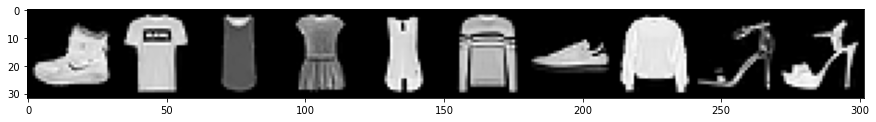

In [3]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

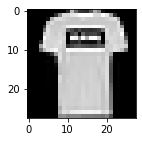

In [4]:
sample_idx = 1
ex_img = images[sample_idx]
grid = torchvision.utils.make_grid(ex_img, nrow=1)
plt.figure(figsize=(2, 2))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [2]:
class UMAP_local_sampling(object):
    def __init__(self, data, dim = 2, random_state = 1):
        """Init function.

        Args:
            data: traning data
        """
        self.dim = dim
        self.no_training, self.channels, self.rows, self.cols = data.shape
        data_1d = data.reshape((self.no_training, self.channels*self.rows*self.cols))
        self.mapper = umap.UMAP(n_components = self.dim, random_state = random_state).fit(data_1d)
    
    def transform(self, data):
        no_data, channels, rows, cols = data.shape
        return self.mapper.transform(data.reshape(no_data, channels*rows*cols))
    
    def inv_transform(self, low_data):
        no_data, low_dim = low_data.shape
        
        assert low_dim == self.dim, "Mismatched dimension"
        
        inv_1d_imgs = self.mapper.inverse_transform(low_data)
        inv_imgs_np = inv_1d_imgs.reshape((no_data, self.channels, self.rows, self.cols))
        inv_imgs = torch.from_numpy(inv_imgs_np)
        
        return inv_imgs
    
    def gen_perturbation_base(self, X, perturbation_multiplier=10, 
                           perturbation_std = 0.3, 
                           train = True,
                           data_min = 0.0,
                           data_max = 1.0):
    
        all_x, all_y = [], []
        var = 0
        if train == True:
            for _ in range(perturbation_multiplier):
                perturbed_xtrain = np.random.normal(0, perturbation_std, size=X.shape) 
                p_train_x = np.vstack((X, X + perturbed_xtrain))
                p_train_y = np.concatenate((np.zeros(X.shape[0]), np.ones(X.shape[0])))

                all_x.append(p_train_x)
                all_y.append(p_train_y)
                var = var + np.var(perturbed_xtrain)
            all_x = np.vstack(all_x)
            all_y = np.concatenate(all_y)

            return all_x, np.sqrt(var/perturbation_multiplier), all_y
        else:
            for _ in range(perturbation_multiplier):
                perturbed_xtrain = np.random.normal(0, perturbation_std, size=X.shape) 
                p_train_x = np.clip(X + perturbed_xtrain, data_min, data_max)
                all_x.append(p_train_x)
                var = var + np.var(p_train_x.numpy() - X.numpy())
            all_x = np.vstack(all_x)

            return all_x, np.sqrt(var/perturbation_multiplier)
        
    def to_1d(self, data):
        return data.reshape((data.shape[0], self.channels*self.rows*self.cols))
    
    def to_3d(self, data):
        return data.reshape((data.shape[0], self.channels, self.rows, self.cols))
            
    
    def get_G(self, x, perturbation_multiplier = 100, std_value = 0.2):
        x_sample, std_sample = self.gen_perturbation_base(x.unsqueeze(0), 
                                                perturbation_multiplier=perturbation_multiplier, 
                                               perturbation_std = std_value, 
                                               train = False)
        
        matA = self.transform(x_sample)
        matB = self.to_1d(x_sample)
        Xt = np.transpose(matA)
        XtX = np.dot(Xt,matA)
        Xty = np.dot(Xt,matB)
        matG = np.linalg.solve(XtX,Xty)
        
        return matG
    
    def get_hyperplane_perturbation(self, x, per_type = 'low_plane',
                                   train_multiplier = 100, std_train = 0.2,
                                   perturbation_multiplier = 1, std_value = 0.1,
                                   data_min = 0.0, data_max = 1.0,
                                   distance = False):
        
        matG = self.get_G(x, perturbation_multiplier = train_multiplier, std_value = std_train)
        x_sample, std_sample, y_sample = self.gen_perturbation_base(x.unsqueeze(0), 
                                                   perturbation_multiplier=perturbation_multiplier, 
                                                   perturbation_std = std_value, 
                                                   train = True)
        x_sample = np.clip(x_sample, data_min, data_max)
        
        if per_type == 'low_plane':
            x_sample_low = self.transform(torch.tensor(x_sample[y_sample == 1]))
            x_reverse = np.clip(np.dot(x_sample_low, matG), data_min, data_max)
            x_reverse_3d = self.to_3d(x_reverse)
            std_real = np.var(x_reverse_3d - x_sample[y_sample != 1])
            x_sample[y_sample == 1] = x_reverse_3d
            
            if distance == False:
                return x_sample, std_real, y_sample
            else:
                x_ori_low = self.transform(torch.tensor(x_sample[y_sample != 1]))
                d = np.linalg.norm(x_ori_low - x_sample_low, axis=1)
                return x_sample, std_real, d, y_sample
                
        else:
            Gu, Gd, Gv = np.linalg.svd(matG, full_matrices=False)
            
            raw_noise = x_sample[y_sample == 1] - x_sample[y_sample != 1]
            raw_noise_1d = umap_sampling.to_1d(raw_noise)
            
            plane_noise = np.zeros_like(raw_noise_1d)
            for d in range(Gv.shape[0]):
                proj = np.dot(raw_noise_1d, Gv[d])
                for s in range(plane_noise.shape[0]):
                    plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]  
                    
            ortho_noise = raw_noise_1d - plane_noise
            ortho_noise_3d = umap_sampling.to_3d(ortho_noise)
            plane_noise_3d = umap_sampling.to_3d(plane_noise)
            if per_type == 'on_plane':
                x_sample[y_sample == 1] = np.clip(x_sample[y_sample == 1] - ortho_noise_3d, data_min, data_max)
                std_real = np.var(x_sample[y_sample == 1] - x_sample[y_sample != 1])
            elif per_type == 'perp_plane':
                x_sample[y_sample == 1] = np.clip(x_sample[y_sample == 1] - plane_noise_3d, data_min, data_max)
                std_real = np.var(x_sample[y_sample == 1] - x_sample[y_sample != 1])
            
            if distance == False:
                return x_sample, std_real, y_sample
            else:
                x_sample_low = self.transform(torch.tensor(x_sample[y_sample == 1]))
                x_ori_low = self.transform(torch.tensor(x_sample[y_sample != 1]))
                d = np.linalg.norm(x_ori_low - x_sample_low, axis=1)
                return x_sample, std_real, d, y_sample
        

In [3]:
start_time = time.time()
umap_sampling = UMAP_local_sampling(all_images)
umap_duration = time.time() - start_time
print("UMAP duration: ", umap_duration)

UMAP duration:  71.89365673065186


In [25]:
idx_0 = (all_labels == 0).nonzero(as_tuple=False)
idx_1 = (all_labels == 1).nonzero(as_tuple=False)

In [33]:
idx_01 = torch.cat((idx_0,idx_1), dim = 0)

In [98]:
import random

def get_pivot(self, labels, no_pivots_per_label = 1, shuffle = False):
    buff = ()
    for l in torch.unique(labels):
        all_idx = (labels == l).nonzero(as_tuple=False)
        
        if shuffle == False:
            idx = all_idx[range(no_pivots_per_label)]
        else:
            idx = all_idx[random.sample(range(len(all_idx)),no_pivots_per_label )]
            
        buff = buff + (idx,)
        
    return torch.cat(buff, dim = 0)

In [102]:
bg_index = get_pivot(all_labels, no_pivots_per_label = 2, shuffle = False)

In [124]:
x_n, std_n, d_n, y_n = umap_sampling.get_hyperplane_perturbation(ex_img, per_type = 'low_plane', perturbation_multiplier=2000, std_value = 0.5, distance = True)
# x_n_p, std_n_p, d_p, y_n_p = umap_sampling.get_hyperplane_perturbation(ex_img, per_type = 'on_plane', perturbation_multiplier=100, std_value = 0.2, distance = True)
# x_n_o, std_n_o, d_o, y_n_o = umap_sampling.get_hyperplane_perturbation(ex_img, per_type = 'perp_plane', perturbation_multiplier=100, std_value = 0.2, distance = True)

In [125]:
print(std_n)
print(std_n_p)
print(std_n_o)
# print(d_n.shape)
# print(d_p)
# print(d_o)

0.005616347612796699
0.00013303656399841484
0.023883495731463852


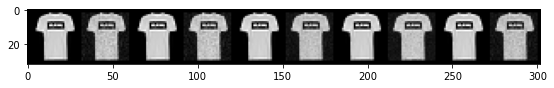

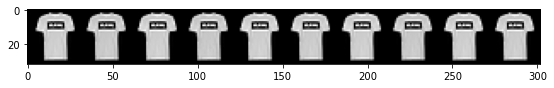

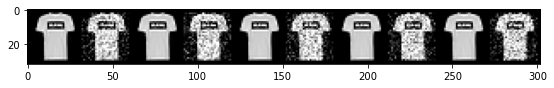

In [126]:
grid = torchvision.utils.make_grid(torch.tensor(x_n[0:10]), nrow=10)
plt.figure(figsize=(20, 1))
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(x_n_p[0:10]), nrow=10)
plt.figure(figsize=(20, 1))
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(x_n_o[0:10]), nrow=10)
plt.figure(figsize=(20, 1))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [45]:
from sklearn import linear_model

def similarity_kernel(d,kernel_width = 1):
    return np.exp(- (d**2) / (kernel_width**2))

print(std_n)
print(std_n_p)
print(std_n_o)
print(d_n.shape)
# print(d_p)
# print(d_o)

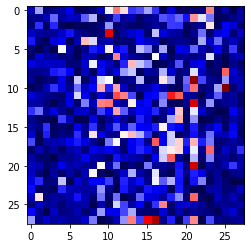

In [131]:
X_per = torch.tensor(x_n[y_n == 1])
X_ori = torch.tensor(x_n[y_n == 0])
X_dist = np.asarray([similarity_kernel(d, kernel_width = 1000) for d in list(d_n)])

original_output = model(ex_img.unsqueeze(0).to(device))
original_prediction = torch.max(original_output, 1)[1]
perturb_outputs = model(X_per.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)
perturb_targets = probs[:,original_prediction.item()].cpu().detach().numpy()

clf = linear_model.Ridge(alpha = 1000)
# clf = linear_model.Lasso(alpha = 0.00001)
true_perturb = np.abs(X_per - X_ori)
no_samples, channels, rows, cols = true_perturb.shape
clf.fit(true_perturb.reshape(no_samples, channels*rows*cols), perturb_targets, sample_weight=X_dist)
explanations = clf.coef_.reshape(rows, cols)
plt.figure()
plt.imshow(np.abs(explanations), cmap=plt.get_cmap('seismic'))

In [63]:
np.max(np.abs(explanations))

9.775590941214256e-07

In [ ]:
    original_output = model(test_img.unsqueeze(0).to(device))
    original_prediction = torch.max(original_output, 1)[1]
    perturb_outputs = model(inv_perturbations.to(device))
#     perturb_prediction = torch.max(perturb_outputs, 1)[1]
    probs = nn.functional.softmax(perturb_outputs, dim = 1)
    perturb_targets = probs[:,original_prediction.item()].cpu().detach().numpy()
    
    base_embeded = mapper.transform(test_img.reshape(1, channels*rows*cols))
    similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = sim_sigma) for i in range(n_samples)]
    
    clf = linear_model.Ridge(alpha = 100)
    clf.fit(np.abs(true_perturb).reshape(n_samples, channels*rows*cols), perturb_targets, sample_weight=similarities)
    explanations = clf.coef_.reshape(rows, cols)
    plt.figure()
    plt.imshow(explanations, cmap=plt.get_cmap('seismic'))

pretrained/fashionCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

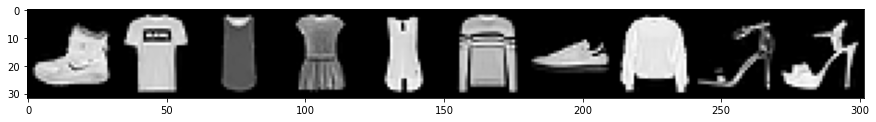

In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

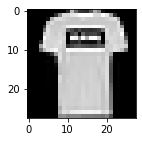

In [6]:
sample_idx = 1
ex_img = images[sample_idx]
grid = torchvision.utils.make_grid(ex_img, nrow=1)
plt.figure(figsize=(2, 2))
plt.imshow(np.transpose(grid, (1, 2, 0)))

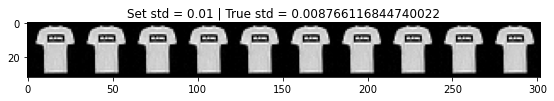

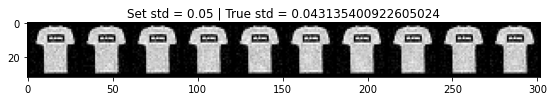

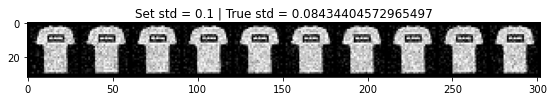

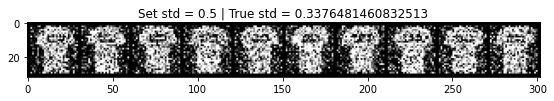

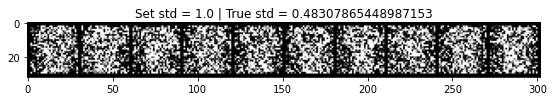

In [7]:
std_values = [0.01, 0.05, 0.1, 0.5, 1.0]
c_dict = dict(zip(std_values,range(len(std_values))))

stds_x, stds_y = [], []
for std_value in std_values:
    x_n, std_n = umap_sampling.gen_perturbation_base(ex_img.unsqueeze(0), perturbation_multiplier=20, 
                                               perturbation_std = std_value, 
                                               train = False)
    stds_x.append(x_n)
    stds_y.append(np.ones(x_n.shape[0])*std_value)
    grid = torchvision.utils.make_grid(torch.tensor(x_n[0:10]), nrow=10)
    plt.figure(figsize=(20, 1))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("Set std = " + str(std_value) + " | True std = " + str(std_n))
    
stds_x = np.vstack(stds_x)
stds_y = np.concatenate(stds_y) 

In [8]:
stds_low_x = umap_sampling.transform(torch.tensor(stds_x))

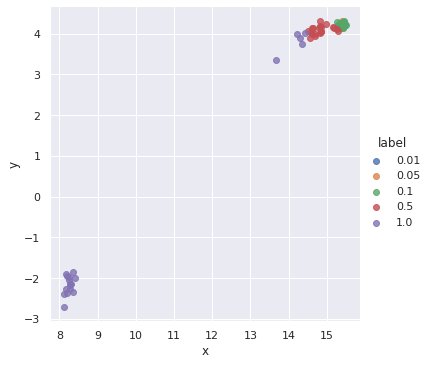

In [9]:
#plot data with seaborn
panda_for_plot = pd.DataFrame(columns=['x','y','label'])
panda_for_plot['x'] = stds_low_x[:,0]
panda_for_plot['y'] = stds_low_x[:,1]
panda_for_plot['label'] = stds_y

sns.set_theme(color_codes=True)

facet = sns.lmplot(data=panda_for_plot, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

Text(0.5, 1.0, 'Set std = 0.2 | True std = 0.15856444575261214')

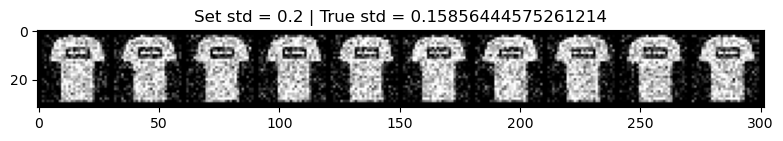

In [10]:
std_value = 0.2

x_test, std_n = umap_sampling.gen_perturbation_base(ex_img.unsqueeze(0), perturbation_multiplier=20*5, 
                                               perturbation_std = std_value, 
                                               train = False)

y_test = np.ones(x_test.shape[0])*std_value
sns.reset_defaults()
grid = torchvision.utils.make_grid(torch.tensor(x_test[0:10]), nrow=10)
plt.figure(figsize=(20, 1))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title("Set std = " + str(std_value) + " | True std = " + str(std_n))

In [110]:
matA = umap_sampling.transform(x_test)
matB = umap_sampling.to_1d(x_test)

In [111]:
# Compute matG
Xt = np.transpose(matA)
XtX = np.dot(Xt,matA)
Xty = np.dot(Xt,matB)
matG = np.linalg.solve(XtX,Xty)
# print(beta)

In [113]:
reverse_x = np.dot(matA,matG)
reverse_x_3d = umap_sampling.to_3d(reverse_x)

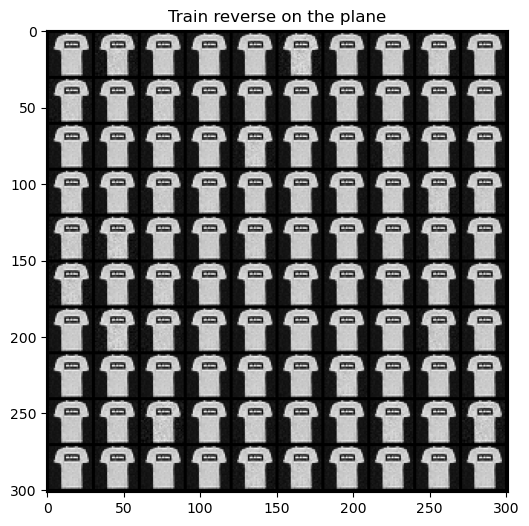

In [114]:
sns.reset_defaults()
grid = torchvision.utils.make_grid(torch.tensor(np.abs(reverse_x_3d)), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Train reverse on the plane")
plt.imshow(np.transpose(grid, (1, 2, 0)))

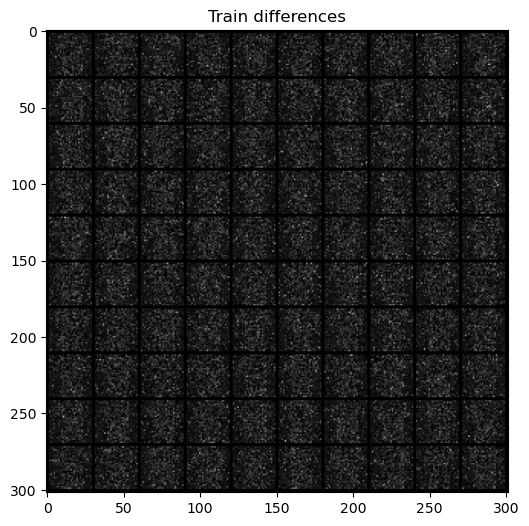

In [115]:
sns.reset_defaults()
grid = torchvision.utils.make_grid(torch.tensor(np.abs(reverse_x_3d-x_test)), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Train differences")
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [116]:
stds_low = umap_sampling.transform(stds_x)
stds_reverse = np.dot(stds_low,matG)
stds_reverse_3d = umap_sampling.to_3d(stds_reverse)

In [130]:
# torch.cat(100*[ex_img.unsqueeze(0)]).shape

torch.Size([100, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


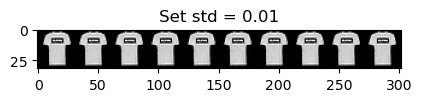

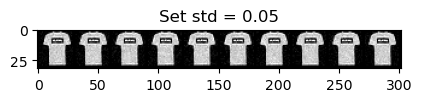

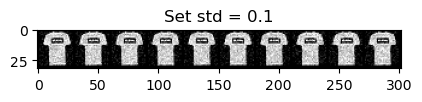

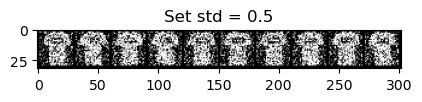

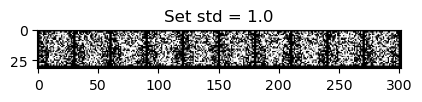

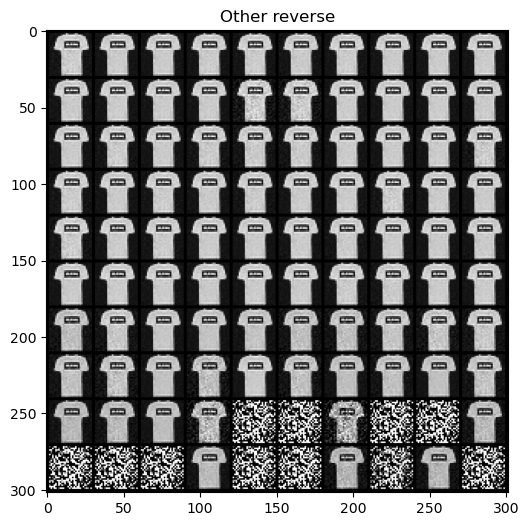

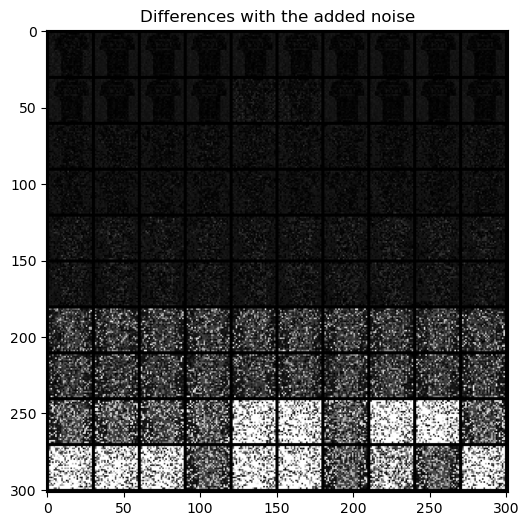

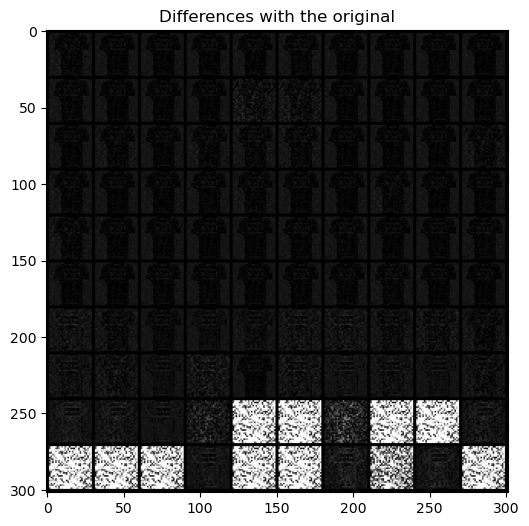

In [132]:
sns.reset_defaults()
count = 0
for std_value in std_values:
    grid = torchvision.utils.make_grid(torch.tensor(stds_x[0+count*20:10+count*20]), nrow=10)
    plt.figure(figsize=(10, 0.5))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("Set std = " + str(stds_y[count*20]))
    count = count +1

grid = torchvision.utils.make_grid(torch.tensor(stds_reverse_3d), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Other reverse")
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(np.abs(stds_reverse_3d - stds_x)), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Differences with the added noise")
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(np.abs(stds_reverse_3d - torch.cat(100*[ex_img.unsqueeze(0)]).numpy() )), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Differences with the original")
plt.imshow(np.transpose(grid, (1, 2, 0)))


In [119]:
others_low = umap_sampling.transform(images)
reverse_others = np.dot(others_low, matG)
reverse_others_3d = umap_sampling.to_3d(reverse_others)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


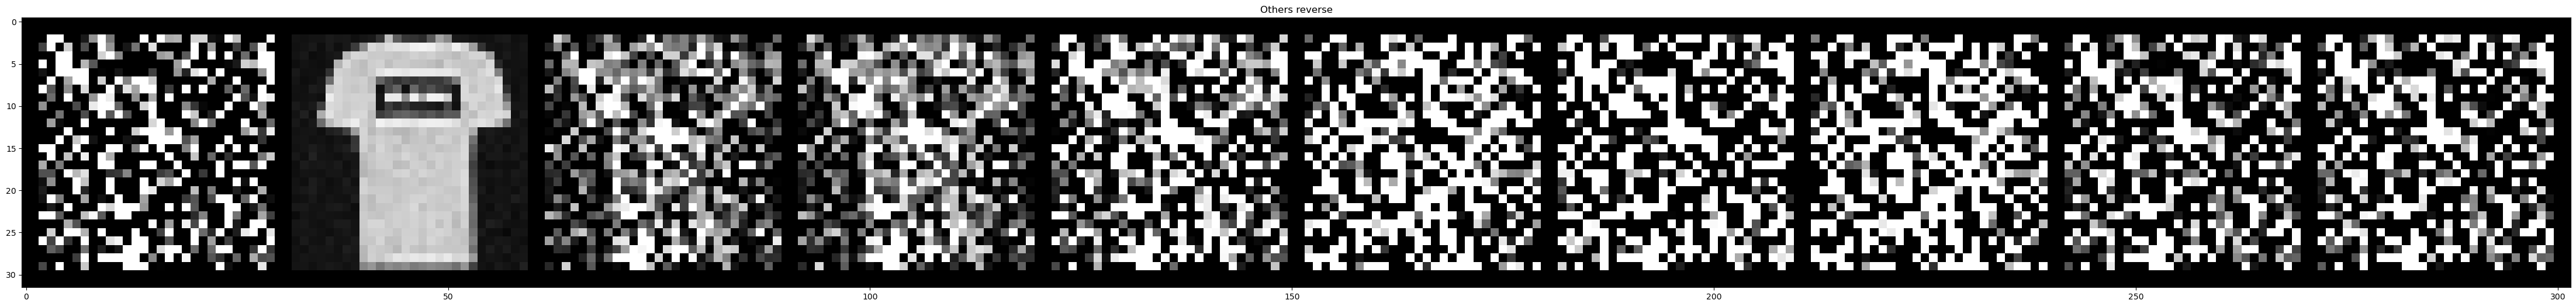

In [120]:
grid = torchvision.utils.make_grid(torch.tensor(reverse_others_3d), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Others reverse")
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [261]:
raw_noise = stds_x - torch.cat(100*[ex_img.unsqueeze(0)]).numpy()
raw_noise_1d = umap_sampling.to_1d(raw_noise)



In [262]:
Gu, Gd, Gv = np.linalg.svd(matG, full_matrices=False)

In [263]:
plane_noise = np.zeros_like(raw_noise_1d)
for d in range(Gv.shape[0]):
    proj = np.dot(raw_noise_1d, Gv[d])
    for s in range(plane_noise.shape[0]):
        plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
ortho_noise = raw_noise_1d - plane_noise

In [264]:
buff_list = []
for s in range(plane_noise.shape[0]):
    buff_list.append(np.max(np.sum(ortho_noise[s]**2) + np.sum(plane_noise[s]**2) - np.sum(raw_noise_1d[s]**2)))
# print(np.max(ortho_noise[s]**2 + plane_noise[s]**2 - raw_noise_1d[s]**2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


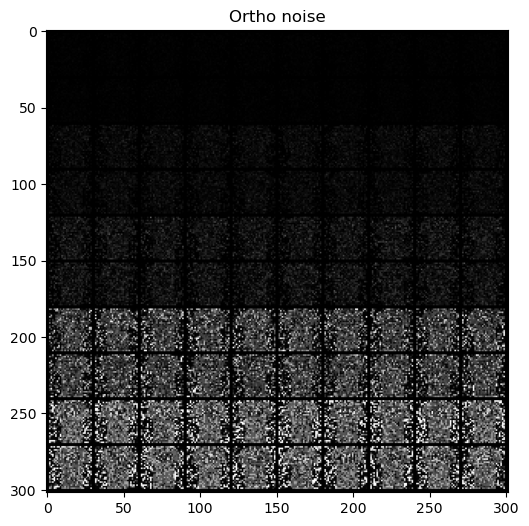

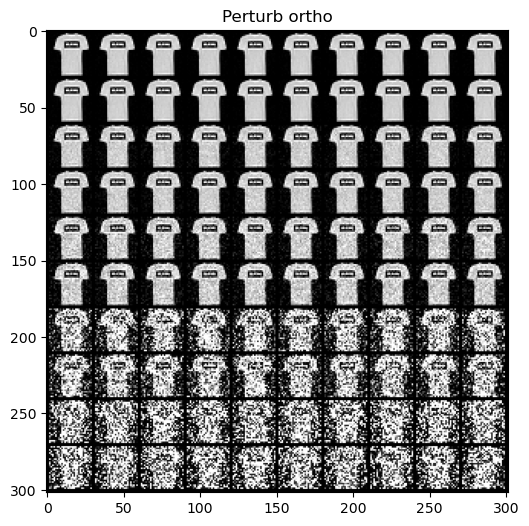

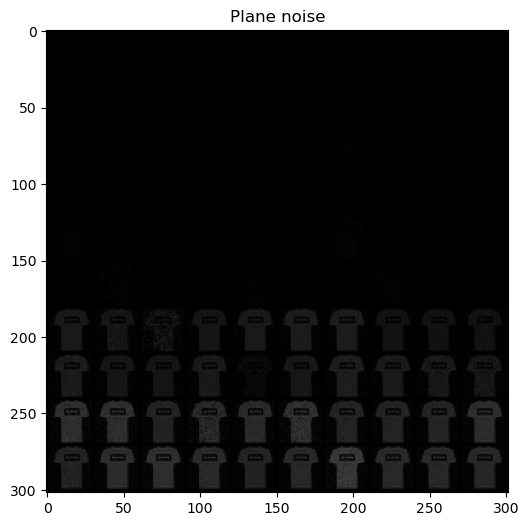

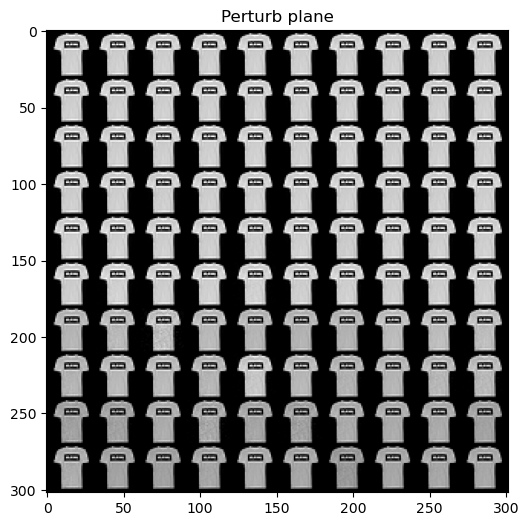

In [266]:
ortho_noise_3d = umap_sampling.to_3d(ortho_noise)
plane_noise_3d = umap_sampling.to_3d(plane_noise)
grid = torchvision.utils.make_grid(torch.tensor(np.abs(ortho_noise_3d )), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Ortho noise")
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(ortho_noise_3d + torch.cat(100*[ex_img.unsqueeze(0)]).numpy()), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Perturb ortho")
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(np.abs(plane_noise_3d )), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Plane noise")
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(torch.tensor(plane_noise_3d + torch.cat(100*[ex_img.unsqueeze(0)]).numpy()), nrow=10)
plt.figure(figsize=(60, 6))
plt.title("Perturb plane")
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [249]:
x_per = ortho_noise_3d + torch.cat(100*[ex_img.unsqueeze(0)]).numpy()

In [250]:
x_per.shape

(100, 1, 28, 28)